# ZRE - Practicals 3

In [68]:
!wget https://codeload.github.com/Marek324/butfit-zre-labs/zip/refs/heads/master -O repo.zip
!unzip repo.zip "butfit-zre-labs-master/*" -d repo
!mv repo/butfit-zre-labs-master/* .
!rm -rf repo.zip repo *.md cv*

--2025-05-16 14:15:39--  https://codeload.github.com/Marek324/butfit-zre-labs/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16085410 (15M) [application/zip]
Saving to: ‘repo.zip’

repo.zip            100%[===================>]  15.34M  16.9MB/s    in 0.9s    

2025-05-16 14:15:40 (16.9 MB/s) - ‘repo.zip’ saved [16085410/16085410]

Archive:  repo.zip
08f4e45110660b1c661071d8e32fb37ee1206b19
   creating: repo/butfit-zre-labs-master/
 extracting: repo/butfit-zre-labs-master/.gitignore  
 extracting: repo/butfit-zre-labs-master/.python-version  
  inflating: repo/butfit-zre-labs-master/.venv_req.txt  
 extracting: repo/butfit-zre-labs-master/README.md  
   creating: repo/butfit-zre-labs-master/audio/
  inflating: repo/butfit-zre-labs-master/audio/buongiorno16.wav  
  inflating: repo/butfit-zre-labs-master/

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import zre_lib
import librosa
import soundfile as sf
from IPython.display import Audio

In [70]:
def plot_spectrogram(sig, Fs):
    fig, ax = plt.subplots(1,1, figsize=(10,5))
    f, t, spec = sg.spectrogram(sig, fs=Fs, nfft=256, mode='psd')
    # default window is Tukey, nperseg = 256, noverlap = 256/8

    plt.pcolormesh(t, f, 10*np.log10(spec))

    ax.set_ylabel('frequency [Hz]')
    ax.set_xlabel('time [s]')
    plt.tight_layout()

## Ex. 1 Detection of the fundamental tone

### Q1 : HOW?

### 0. Load the signal and take 1 frame (no overlap)

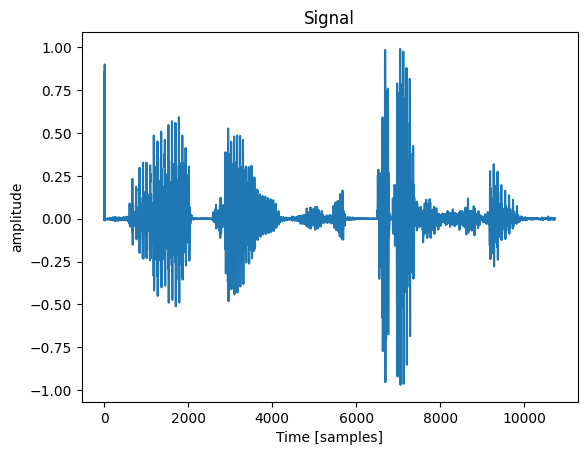

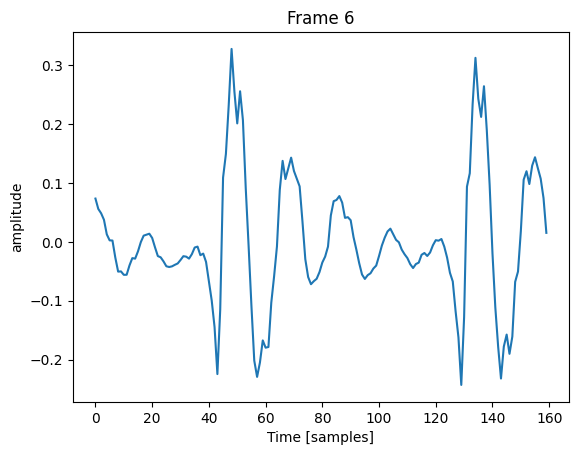

In [71]:
# signal
s, Fs = librosa.load(f'audio/test.wav', sr=8000)
sm = s - s.mean()
plt.plot(sm)
plt.title('Signal')
plt.xlabel('Time [samples]')
plt.ylabel("amplitude")
plt.show()
zre_lib.frame(sm, 160, 0)
sr = zre_lib.frame(sm, 160, 0)
x = sr[6]
plt.plot(x)
plt.title('Frame 6')
plt.xlabel('Time [samples]')
plt.ylabel("amplitude")
plt.show()

### 1.1 Using ACF (Autocorrelation function)

### Q1 Which autocorrelation coefficients are relevant?

Mainly the coefficient of the first major peak which represent lag (number of samples after which signal +- repeats).

### Q2 What values of threshold and lag (Lmin, Lmax) could we use?

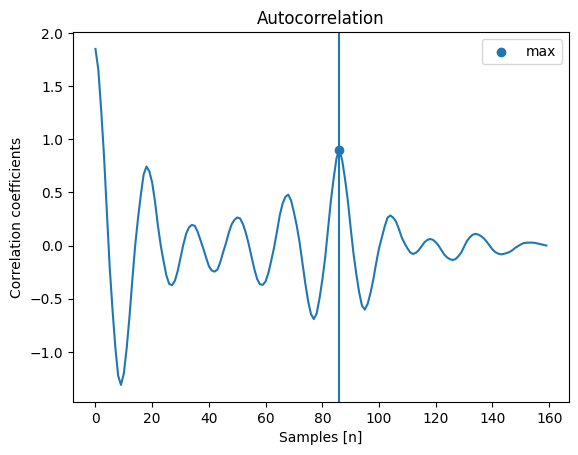

In [72]:
R = np.correlate(x, x, 'full')
R = R[len(R)//2:]
#Frame length = 160 samples
Lmin = 20 # first sample to look at
Lmax = 146 # last one
thr = max(R[Lmin:])/R[0] # threshold value: Rmax/R0 = thr


Rmaxarg = np.argmax(R[Lmin:Lmax])
Racfmax = R[Lmin + Rmaxarg]

if Racfmax >= thr*R[0]:
    Lacf = Lmin + Rmaxarg
else:
    Lacf = 0
plt.plot(R)
plt.scatter(Lacf, Racfmax, label='max')
plt.axvline(Lacf)
plt.title('Autocorrelation')
plt.ylabel('Correlation coefficients')
plt.xlabel('Samples [n]')
plt.legend()
plt.show()

In [73]:
# fill correct term
print(f'Lag = {Lacf} samples')
print(f'T0 = {Lacf/Fs} s')
print(f'f0 = {Fs/Lacf} Hz')

Lag = 86 samples
T0 = 0.01075 s
f0 = 93.02325581395348 Hz


### 1.2 Using NCFF (normalized cross correlation function)

#### 1.2.1. Define selected frame, calculate its energy E1 for normalization.

In [74]:
start = (7 - 1) * 160
end = start + 160

selected = sm[start:end]
E1 = sum(x**2) # frame's energy

#### 1.2.2. Calculate NCCF between the selected frame and the shifted ones
Shift the signal and calculate the normalized correlation coefficient.


![image.png](attachment:image.png)

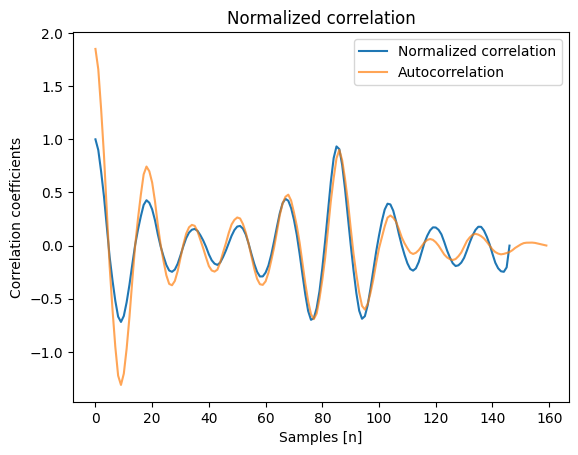

In [75]:
Rnccf = np.zeros(Lmax+1)
for n in range(Lmax):
    start_shifted = start - n
    end_shifted = end - n
    shifted = sm[start_shifted:end_shifted]
    E2 = sum(x**2) # Energy of the shifted frame
    numerator = np.sum(selected * shifted)#
    nccf = numerator / np.sqrt(E1*E2)
    Rnccf[n] = nccf
plt.plot(Rnccf, label='Normalized correlation')
plt.plot(R, label='Autocorrelation', alpha=0.7)
plt.title('Normalized correlation')
plt.ylabel('Correlation coefficients')
plt.xlabel('Samples [n]')
plt.legend()
plt.show()

Spot Rmax from autocorrelation and from NCC

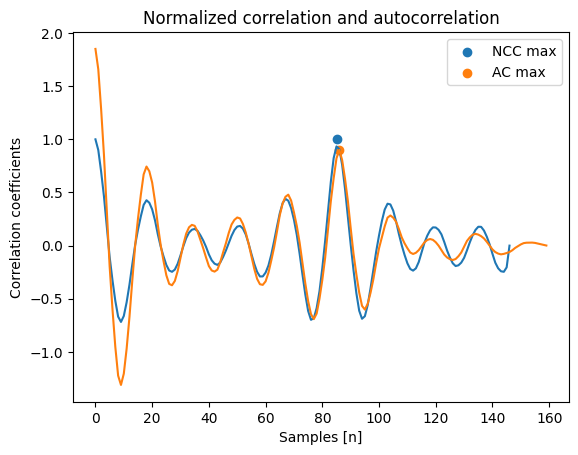

In [76]:
Rmaxarg = np.argmax(Rnccf[Lmin:Lmax])
Rmax = max(Rnccf)
thresholdc = max(Rnccf[Lmin:])/Rnccf[0]

if Rmax >= thresholdc * Rnccf[0]:
    L = Lmin + Rmaxarg
else:
    L = 0
plt.plot(Rnccf)
plt.scatter(L, Rmax, label='NCC max')
plt.plot(R)
plt.scatter(Lacf, Racfmax, label='AC max')

plt.title('Normalized correlation and autocorrelation')
plt.ylabel('Correlation coefficients')
plt.xlabel('Samples [n]')
plt.legend()
plt.show()

In [77]:
# fill correct term
print("NCCF")
print(f'Lag = {L} samples')
print(f'T0 = {L/Fs} s')
print(f'f0 = {Fs/L} Hz')

print("ACF")
print(f'Lag = {Lacf} samples')
print(f'T0 = {Lacf/Fs} s')
print(f'f0 = {Fs/Lacf} Hz')

NCCF
Lag = 85 samples
T0 = 0.010625 s
f0 = 94.11764705882354 Hz
ACF
Lag = 86 samples
T0 = 0.01075 s
f0 = 93.02325581395348 Hz


### 1.3   Fundamental tone detection for the whole signal
Using functions "zre.lag_acf" and "zre.lag_ncff" we calculate the ACF and NCCF for the whole signal.

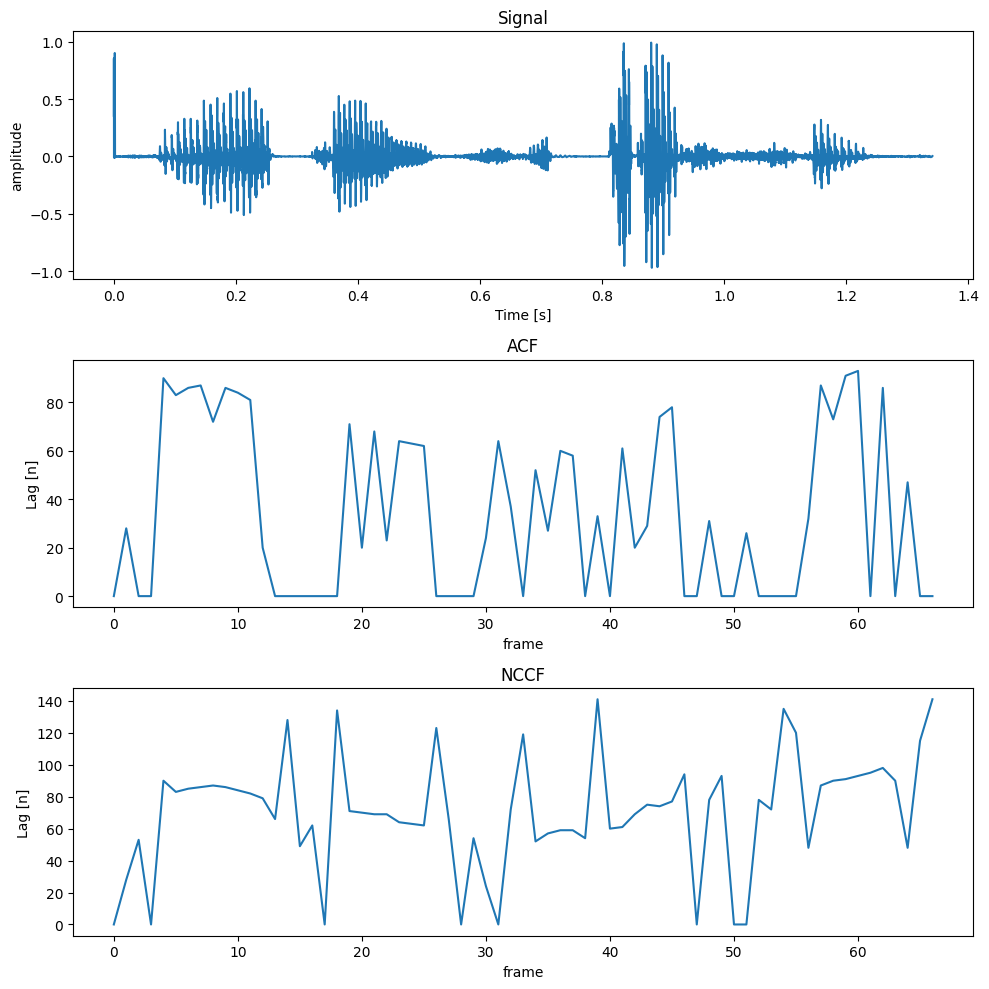

In [78]:
Lacf = zre_lib.lag_acf(sm, 160, 0, Lmin, Lmax, 0.3) # signal, #frame length, #overlap, #starting sample, #ending sample, # threshold
Lnccf = zre_lib.lag_nccf(sm, 160, 0, Lmin, Lmax, 0.3)
fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(np.arange(len(sm))/Fs, sm)
ax[0].set_title('Signal')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('amplitude')
ax[1].plot(Lacf)
ax[1].set_title('ACF')
ax[1].set_xlabel('frame')
ax[1].set_ylabel('Lag [n]')
ax[2].plot(Lnccf)
ax[2].set_title('NCCF')
ax[2].set_xlabel('frame')
ax[2].set_ylabel('Lag [n]')
plt.tight_layout()
plt.show()

### Q4: What values must NCCF[0] have and why?

0th coefficient is the signal correlated with itself so the normalized correlation is always 1.

### Q5: Which method is better and why?

NCCF is more accurate because of it's robustness but it's also more computationaly complex.

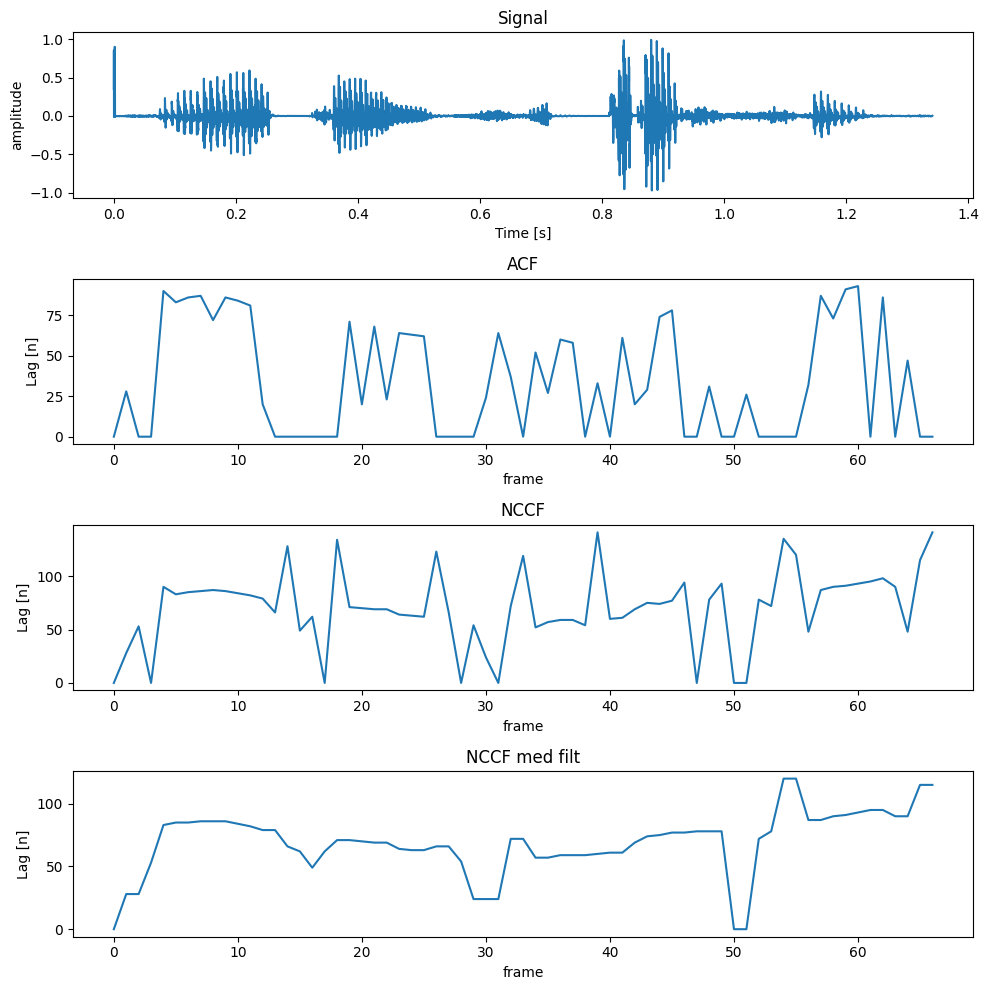

In [79]:
Lnccf_med = sg.medfilt(Lnccf, 3)
fig, ax = plt.subplots(4,1, figsize=(10,10))
ax[0].plot(np.arange(len(sm))/Fs, sm)
ax[0].set_title('Signal')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel("amplitude")
ax[1].plot(Lacf)
ax[1].set_title('ACF')
ax[1].set_xlabel('frame')
ax[1].set_ylabel('Lag [n]')
ax[2].plot(Lnccf)
ax[2].set_title('NCCF')
ax[2].set_xlabel('frame')
ax[2].set_ylabel('Lag [n]')
ax[3].plot(Lnccf_med)
ax[3].set_title('NCCF med filt')
ax[3].set_xlabel('frame')
ax[3].set_ylabel('Lag [n]')

plt.tight_layout()
plt.show()

In [80]:
Audio(f"audio/train.wav")

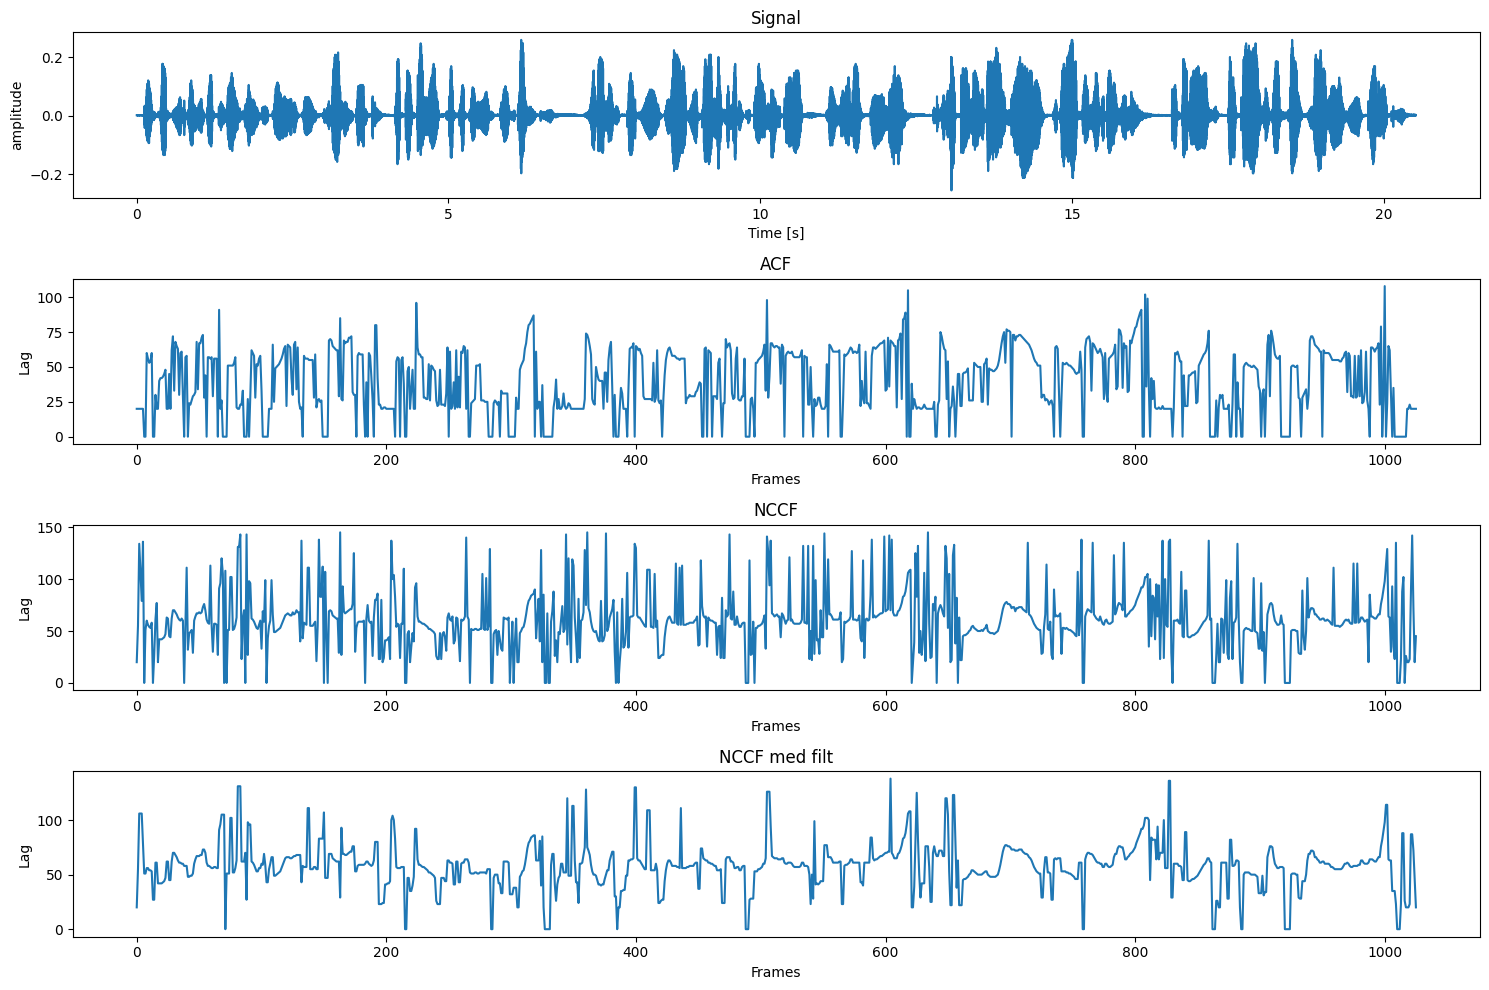

In [81]:
s, _ = librosa.load(f'audio/train.wav', sr=Fs)
sm = s - np.mean(s)
Lacf = zre_lib.lag_acf(sm, 160, 0, Lmin, Lmax, 0.3)
Lnccf = zre_lib.lag_nccf(sm, 160, 0, Lmin, Lmax, 0.3)
Lnccf_med = sg.medfilt(Lnccf, 3)
fig, ax = plt.subplots(4,1, figsize=(15,10))
ax[0].plot(np.arange(len(sm))/Fs, sm)
ax[1].plot(Lacf)
ax[2].plot(Lnccf)
ax[3].plot(Lnccf_med)
ax[0].set_title('Signal')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('amplitude')
ax[1].set_title('ACF')
ax[1].set_xlabel('Frames')
ax[1].set_ylabel('Lag')
ax[2].set_title('NCCF')
ax[2].set_xlabel('Frames')
ax[2].set_ylabel('Lag')
ax[3].set_title('NCCF med filt')
ax[3].set_xlabel('Frames')
ax[3].set_ylabel('Lag')

plt.tight_layout()
plt.show()

### Q6: Write a pseudocode for online calculation of NCCF (when you don't have the whole signal beforehand)

### Q7: What could be a better combination of hyperparameters (threshold, Lmin, Lmax)?

### Q8: Try using a different filter length. How does the result change?

### Q9: Does the ACFF and NCCF work if we add noise to the signal? Try it.

### Bonus: Try to filter out from each frame the fundamental frequency using a lowpass filter. What happens?

## Ex. 2 Building a Codec - Coding and Decoding
Try to create a speech encoder working on bit rate 1050 bit/s. The output won't be a bit stream but a text file with integer numbers (which can be coded in bits)



### 2.1 Calculation of parameters and coding without quantization
Use LPC analysis and Fundamental frequency detection over all frames. Analyse and synthesize without quantization.

In [82]:
s = librosa.load(f'audio/train.wav', sr=Fs)[0]
# center signal
sm = s - np.mean(s)
A, G, L, Nram = zre_lib.param2(sm, lram = 160, pram = 0, P = 10, Lmin = 20, Lmax = 146, thr = 0.7) #
# A : LPC coefficients - len(A) = P
# G : gain (sqrt(sum(E)) - len(G) = Nram
# L : normalized and filtered NCCF coefficients with median filter (LAGS) - len(L) = Nram
# Nram : number of frames

#### 2.1 Synthesize signal using LPC coefficients and fundamental frequencies

#### Q1: What will be used as excitation signal?

Pulse with frequencies based on NCCF coefficients
Noise for NEZNELE frames

#### Q2: What excitation we could use to preserve voice intonation?

filter G/A[z], excite

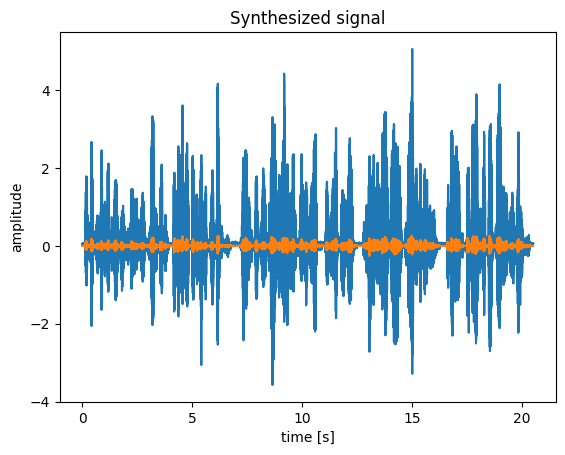

In [83]:
ss21=zre_lib.synthesize(A, G, L, 10, 160)

plt.plot(np.arange(len(sm))/Fs, ss21)
plt.plot(np.arange(len(sm))/Fs, sm)
plt.title("Synthesized signal")
plt.ylabel("amplitude")
plt.xlabel("time [s]")
plt.show()

In [84]:
Audio(sm, rate=Fs)

In [85]:
Audio(ss21, rate=Fs)

In [86]:
# pro srovnani buzeni sumem
ss22=zre_lib.syntnoise(A, G, 10, 160)
Audio(ss22, rate=Fs)

### 2.2 Coding with vector quantization

#### Q3: Using codebook cb201.txt of shape (210, 10) what frame bit-rate do we get?

    Lpc codebook cb210 =
    Gain codebook  gcb64 =

In [87]:
cb210 = np.loadtxt('cb210.txt').T # LPC coefficients, shape:  (10, 210)
gcb64 = np.loadtxt('gcb64.txt')  # Gain coefficients, shape: (64)

asym, gd = zre_lib.vq_code(A, cb210)
gsym, gd2 = zre_lib.vq_code(G, gcb64)

#### Q4: Are the filters in cb210.txt stable?

In [88]:
for i in range(cb210.shape[0]):
    assert (np.abs(root) < 1 for root in np.roots(cb210[i]))

#### Q5: what values will asym have? And gsym?

Synthesized LPC and gain coefficients

### 2.3 Decoding quantified signal and synthesize

What do we need for signal synthesis?

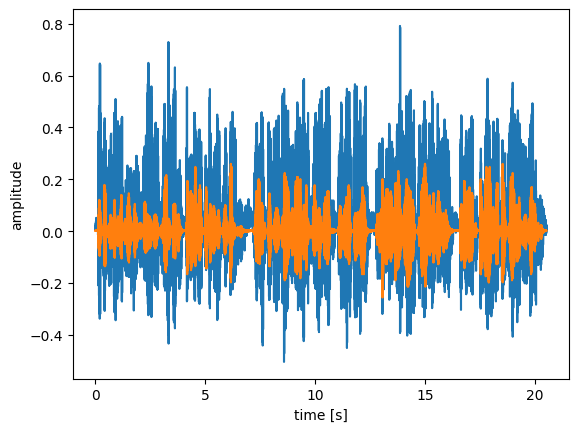

In [89]:
Adecoded = cb210[asym]
Gdecoded = gcb64[gsym]
ss22 = zre_lib.synthesize(Adecoded, Gdecoded, L, 10, 160)
plt.plot(np.arange(len(sm))/Fs, ss22)
plt.plot(np.arange(len(sm))/Fs, sm)
plt.ylabel("amplitude")
plt.xlabel("time [s]")
plt.show()

In [90]:
Audio(ss22, rate = Fs)

#### Q5: What is the final bitrate? Compare with GSM
GSM signal bitrates: (LPC coefficients 36 bits, gain 7 bits, excitation 186 bits )


![image.png](attachment:image.png)

In [91]:
# framerate
# Gbits
# Abits
# exitation signal bits

#### Q6: Why does the codebook have size of 210 instead of 256?

### 2.4 Coding and deconding of different signals (MOS evaluation)


#### Q1: Evaluate the decoded signals (MOS)

![image.png](attachment:image.png)

In [92]:
def coder(in_f, out_f):
    cb210 = np.loadtxt('cb210.txt').T
    gcb64 = np.loadtxt('gcb64.txt')
    s = librosa.load(in_f, sr=Fs)[0]
    sm = s - s.mean()
    A,G,L,Nram = zre_lib.param2(sm, 160,0,10,20,146,0.7)
    asym, gd = zre_lib.vq_code(A, cb210)
    gsym, gd2 = zre_lib.vq_code(G, gcb64)
    np.save(out_f, (asym, gsym, L))
    return s

def decoder(in_f, out_f, noise=False):
    cb210 = np.loadtxt('cb210.txt').T
    gcb64 = np.loadtxt('gcb64.txt')
    try:
        (asym, gsym, L) = np.load(in_f)
    except FileNotFoundError:
        (asym, gsym, L) = np.load(f'{in_f}.npy')
    Adecoded = cb210[asym.astype(int)]
    Gdecoded = gcb64[gsym.astype(int)]
    if noise:
        ss = zre_lib.syntnoise(Adecoded, Gdecoded, 10, 160)
    else:
        ss = zre_lib.synthesize(Adecoded, Gdecoded, L.astype(int), 10, 160)
    sf.write(out_f, ss, samplerate=Fs)
    return ss


#### 2.4.1 Female speaker signal

In [93]:
scF = coder(f'audio/woman.wav', 'woman_code')
sdF = decoder('woman_code', f'audio/woman_decoded.wav')

In [94]:
Audio(f"audio/woman.wav")

In [95]:
Audio(f"audio/woman_decoded.wav")

#### 2.4.2 Male speaker signal

In [96]:
sc1 = coder(f'audio/testspdat.wav', 'test_code1')
sd1 = decoder('test_code1', f'audio/test_decoded1.wav')
sdn1 = decoder ('test_code1', f'audio/test_decoded1_noise.wav', noise=True)

In [97]:
samemale = librosa.load(f"audio/testspdat.wav", sr = Fs)[0]
Audio(f"audio/testspdat.wav")

In [98]:
Audio(f"audio/test_decoded1.wav")

In [99]:
Audio(f"audio/test_decoded1_noise.wav")

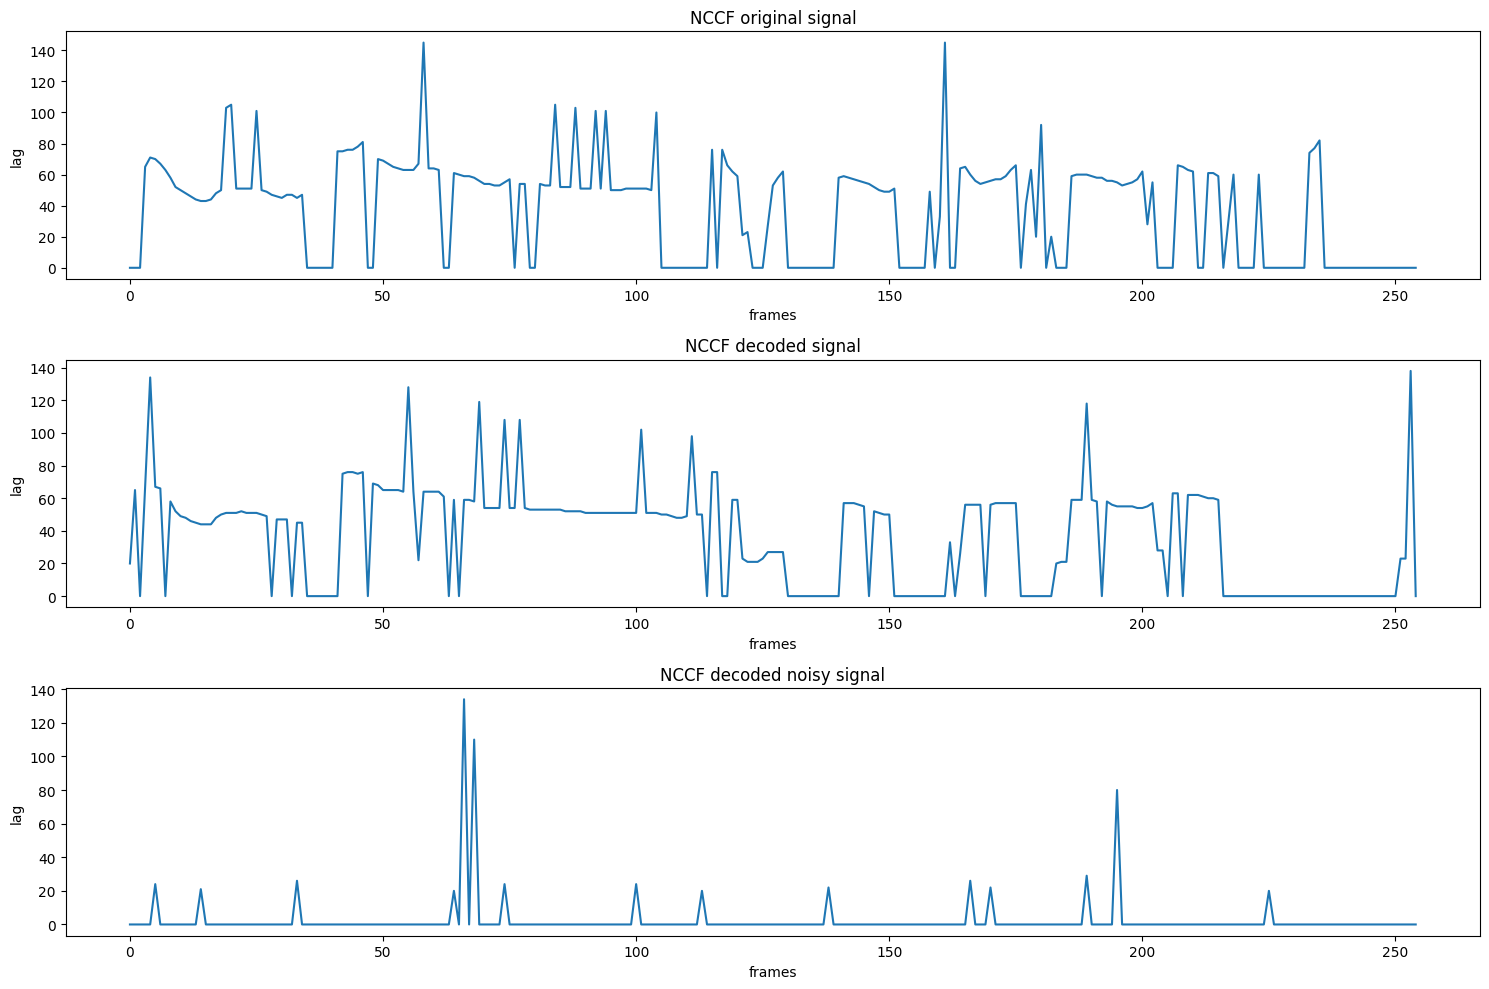

In [100]:
L_orig = zre_lib.lag_nccf(sc1, 160, 0, 20, 146, 0.7)
L_coded = zre_lib.lag_nccf(sd1, 160, 0, 20, 146, 0.7)
L_coded_n = zre_lib.lag_nccf(sdn1, 160, 0, 20, 146, 0.7)
fig, ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(L_orig)
ax[0].set_xlabel("frames")
ax[0].set_ylabel("lag")
ax[0].set_title("NCCF original signal")
ax[1].plot(L_coded)
ax[1].set_xlabel("frames")
ax[1].set_ylabel("lag")
ax[1].set_title("NCCF decoded signal")
ax[2].plot(L_coded_n)
ax[2].set_xlabel("frames")
ax[2].set_ylabel("lag")
ax[2].set_title("NCCF decoded noisy signal")
plt.tight_layout()
plt.show()

#### 2.4.3 Different male speaker

In [101]:
sc2 = coder(f'audio/ses0019.wav', 'test_code2')
sd2 = decoder('test_code2', f'audio/test_decoded2.wav')
Audio(sc2, rate=Fs)

In [102]:
Audio(sd2, rate=Fs)

#### Q2: Compare the coded and decoded parameters - what makes the decodification so bad? How could we make it better? Try to write some examples.

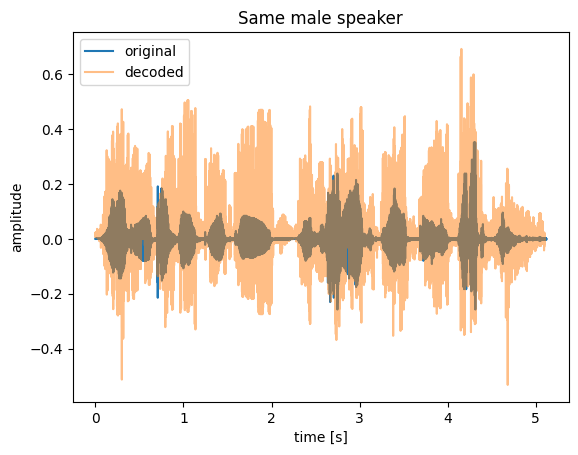

In [103]:
plt.plot(np.arange(len(samemale))/Fs, samemale, label = "original")
plt.plot(np.arange(len(sd1))/Fs, sd1, alpha = 0.5, label = "decoded")
plt.ylabel("amplitude")
plt.xlabel("time [s]")
plt.legend()
plt.title("Same male speaker")
plt.show()

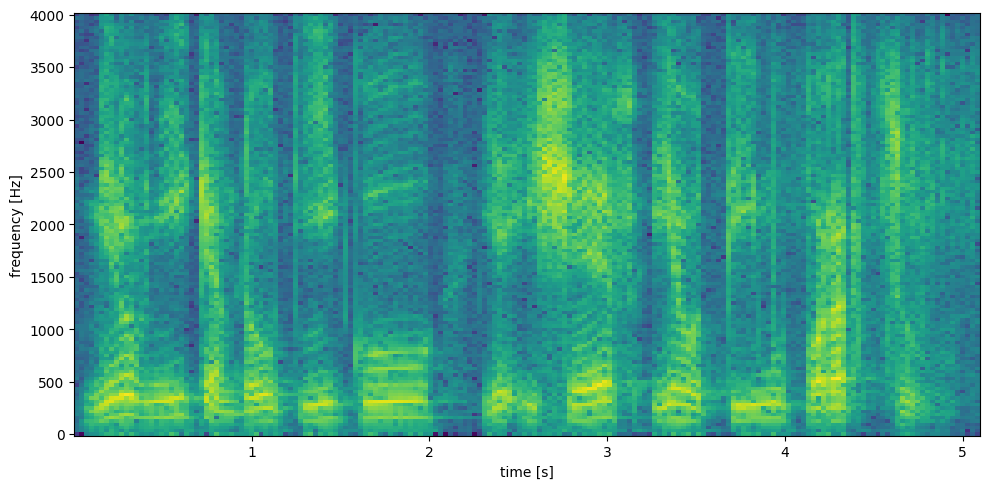

In [104]:
plot_spectrogram(samemale, Fs)

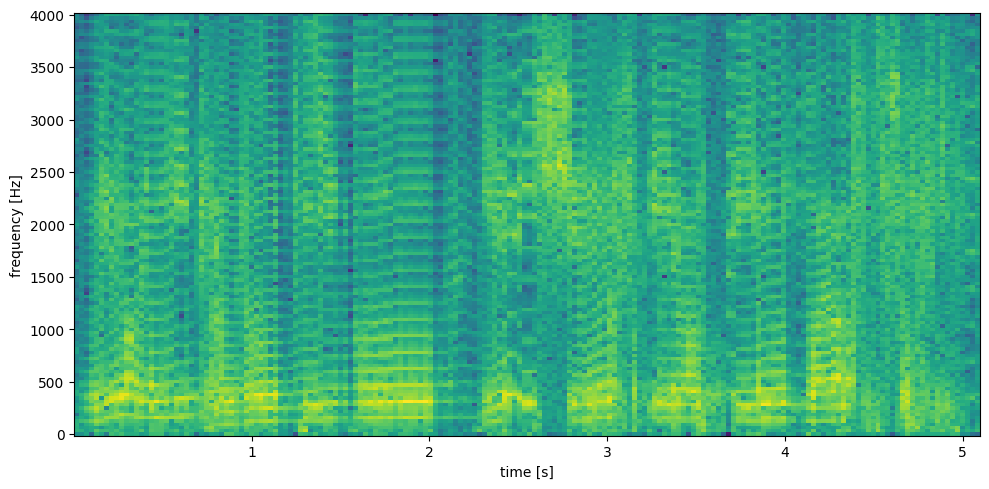

In [105]:
plot_spectrogram(sd1, Fs)

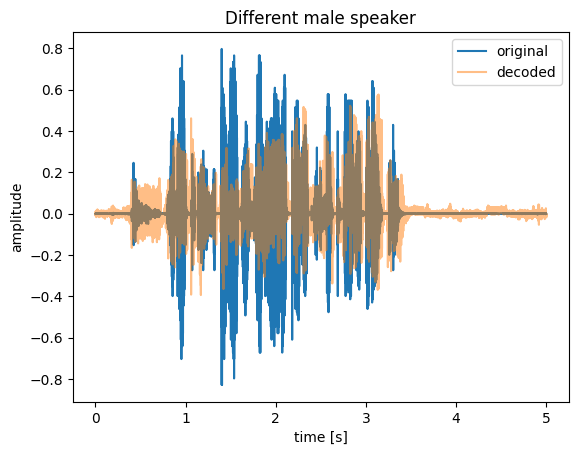

In [106]:
plt.plot(np.arange(len(sc2))[0:5*Fs]/Fs, sc2[0:5*Fs], label = "original")
plt.plot(np.arange(len(sd2))[0:5*Fs]/Fs, sd2[0:5*Fs], alpha = 0.5, label = "decoded")
plt.ylabel("amplitude")
plt.xlabel("time [s]")
plt.title("Different male speaker")
plt.legend()
plt.show()

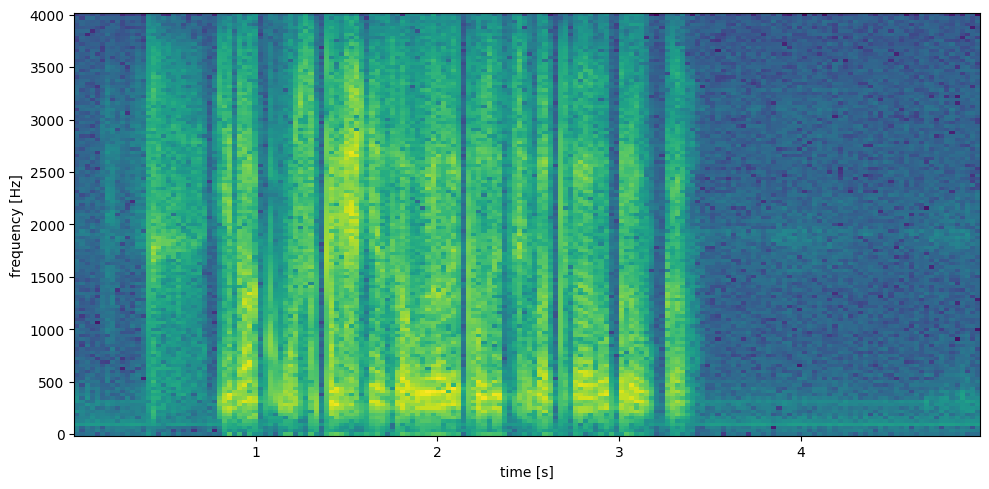

In [107]:
plot_spectrogram(sc2[0:5*Fs], Fs)

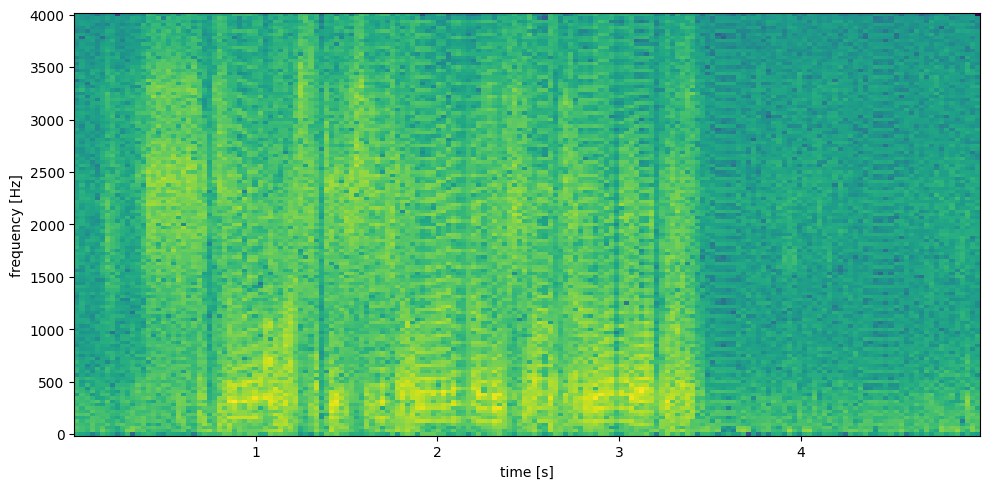

In [108]:
plot_spectrogram(sd2[0:5*Fs], Fs)

#### 2.4.4 Your own voice / signal

### BONUS: Train your own codebook with more speakers, different genders, etc. (remove silence! e.g. using voice activity detector VAD based on shorterm energy)


### BONUS: Create a function that aligns the decoded signal with the coded one using log spectral distance. Calculate PSD with DFT - Calculate the mean and maximum across frames.

Use the following equation to calculate LSD:

![image.png](attachment:image.png)

In [109]:
def calculate_LSD(x, d, Fs=8000, frame_size=160):
    Nram = int(1 + np.floor((len(x) - frame_size) / frame_size))
    xram = np.array([x[i*frame_size:i*frame_size + frame_size] for i in range(Nram)])
    dram = np.array([d[i*frame_size:i*frame_size + frame_size] for i in range(Nram)])
    LSD = np.zeros(Nram)
    for i in range(Nram):
        # Extract frames
        orig_frame = xram[i]
        dec_frame = dram[i]

        # Compute the magnitude spectra (using FFT)
        PSD_Xfft = np.abs(np.fft.fft(orig_frame))[:frame_size // 2]**2
        PSD_Dfft = np.abs(np.fft.fft(dec_frame))[:frame_size // 2]**2
        Vf = 10*np.log(PSD_Xfft)-10*np.log(PSD_Dfft)
        LSD[i] = np.sqrt(np.sum((np.abs(Vf))**2))
    fig = plt.figure()
    plt.xlabel("frame")
    plt.ylabel("LSD")
    plt.title("Log spectral distance")
    plt.plot(LSD)
    plt.show()

    return LSD


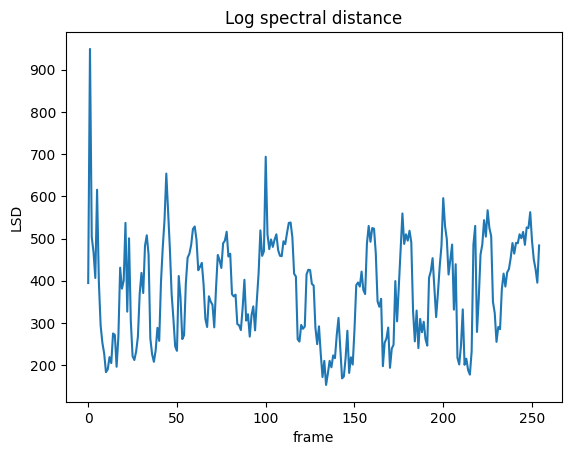

In [110]:
LSD = calculate_LSD(samemale, sd1)

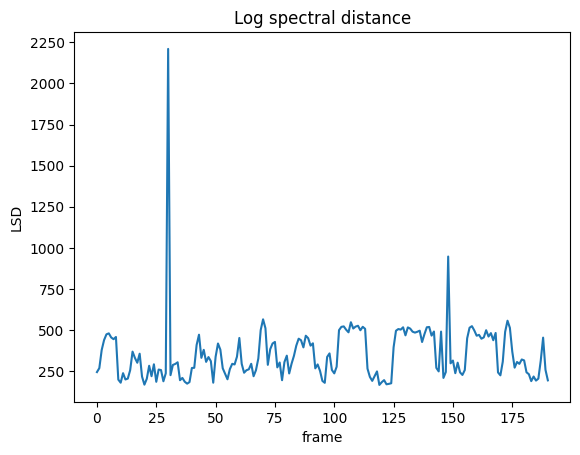

In [111]:
LSD_female = calculate_LSD(scF, sdF)